In [1]:
import visual_behavior_glm.src.GLM_params as glm_params
import visual_behavior_glm.src.GLM_analysis_tools as gat
from visual_behavior_glm.src.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
%matplotlib inline


## get results for glm version 4

In [3]:
results_all = gat.retrieve_results(results_type='full')

In [4]:
results_all['glm_version'].unique()
#use v4

array(['3', '4_L2_optimize_by_session', '4_L2_fixed_lambda=1',
       '4_L2_optimize_by_cell', '2', '4_L2_opt_by_cell_tighter_grid',
       '4_L2_opt_by_session_tighter_grid', '5_L2_fixed_lambda=1',
       '5_L2_optimize_by_cell', '5_L2_optimize_by_session'], dtype=object)

In [5]:
rs = gat.retrieve_results(search_dict = {'glm_version': '4_L2_optimize_by_cell'}, results_type='summary')
len(rs)

1365760

### make a new column called 'identifier' that is {OPHYS_EXPERIMENT_ID}_{CELL_SPECIMEN_ID}. This will give each a unique ID

In [6]:
rs['identifier'] = rs['ophys_experiment_id'].astype(str) + '_' +  rs['cell_specimen_id'].astype(str)

In [7]:
rs

_id  index           dropout  \
0        5f22221a7eeb3a3cbb69c983      0              Full   
1        5f22221a7eeb3a3cbb69c984      1         intercept   
2        5f22221a7eeb3a3cbb69c985      2              time   
3        5f22221a7eeb3a3cbb69c986      3         pre_licks   
4        5f22221a7eeb3a3cbb69c987      4        post_licks   
...                           ...    ...               ...   
1365755  5f24621b2ac3d684bf7369e9     27  model_omissions1   
1365756  5f24621b2ac3d684bf7369ea     28    model_timing1D   
1365757  5f24621b2ac3d684bf7369eb     29        all-images   
1365758  5f24621b2ac3d684bf7369ec     30            visual   
1365759  5f24621b2ac3d684bf7369ed     31         beh_model   

         variance_explained  fraction_change_from_full  \
0                  0.229436                   0.000000   
1                  0.229937                   0.002183   
2                  0.229769                   0.001453   
3                  0.229634                   0.000864   
4                  0.227139                  -0.010010   
...                     ...                        ...   
1365755            0.048034                   0.048249   
1365756            0.048441                   0.057133   
1365757            0.039222                  -0.144061   
1365758            0.034920                  -0.237943   
1365759            0.057378                   0.252150   

         absolute_change_from_full  cell_specimen_id  ophys_experiment_id  \
0                         0.000000        1017215561            991852008   
1                         0.000501        1017215561            991852008   
2                         0.000333        1017215561            991852008   
3                         0.000198        1017215561            991852008   
4                        -0.002297        1017215561            991852008   
...                            ...               ...                  ...   
1365755                   0.002211         962642740            808621034   
1365756                   0.002618         962642740            808621034   
1365757                  -0.006601         962642740            808621034   
1365758                  -0.010903         962642740            808621034   
1365759                   0.011554         962642740            808621034   

         ophys_session_id  behavior_session_id  ...  super_container_id  \
0               991639544            991662910  ...           920877188   
1               991639544            991662910  ...           920877188   
2               991639544            991662910  ...           920877188   
3               991639544            991662910  ...           920877188   
4               991639544            991662910  ...           920877188   
...                   ...                  ...  ...                 ...   
1365755         808340530            808432167  ...           772622653   
1365756         808340530            808432167  ...           772622653   
1365757         808340530            808432167  ...           772622653   
1365758         808340530            808432167  ...           772622653   
1365759         808340530            808432167  ...           772622653   

                  cre_line session_tags failure_tags exposure_number  \
0        Slc17a7-IRES2-Cre          NaN          NaN               0   
1        Slc17a7-IRES2-Cre          NaN          NaN               0   
2        Slc17a7-IRES2-Cre          NaN          NaN               0   
3        Slc17a7-IRES2-Cre          NaN          NaN               0   
4        Slc17a7-IRES2-Cre          NaN          NaN               0   
...                    ...          ...          ...             ...   
1365755  Slc17a7-IRES2-Cre          NaN          NaN               0   
1365756  Slc17a7-IRES2-Cre          NaN          NaN               0   
1365757  Slc17a7-IRES2-Cre          NaN          NaN               0   
1365758  Slc17a7-IRES2-Cre          NaN   

### pivot the table to get it into a form for clustering

#### get fraction change in explained variance after dropout of each regressor

In [8]:
model_output_type = 'fraction_change_from_full'
rsp = rs.pivot(index='identifier',columns='dropout',values=model_output_type).reset_index()
rsp

dropout             identifier  Full  all-images  beh_model    change  \
0        1000743008_1003146172   0.0   -0.140223  -0.001848  0.000581   
1        1000743008_1003146177  -0.0    0.085372  -0.009939 -0.004046   
2        1000743008_1003146180   0.0   -0.155019   0.004636  0.000530   
3        1000743008_1003146183   0.0   -0.210215   0.062499  0.000224   
4        1000743008_1003146186   0.0   -0.368535   0.021722  0.000232   
...                        ...   ...         ...        ...       ...   
42675      995439942_994310000   0.0   -0.485011   0.007001  0.004174   
42676      995439942_994310003   0.0   -1.118526   0.042506  0.000775   
42677      995439942_994310018   0.0   -0.541743   0.006398  0.003886   
42678      995439942_994310024   0.0   -0.277435   0.013547  0.000625   
42679      995439942_995644666  -0.0    2.419058  -0.232475 -0.089610   

dropout  correct_rejects  false_alarms      hits    image0    image1  ...  \
0               0.014875      0.008197  0.005280 -0.000634  0.003108  ...   
1              -0.123170     -0.096961 -0.024053 -0.008854 -0.028034  ...   
2               0.020636      0.011811  0.003584  0.002961  0.003979  ...   
3               0.002435      0.001871  0.001834  0.001881  0.002758  ...   
4               0.002308      0.006869  0.002990 -0.001212 -0.003161  ...   
...                  ...           ...       ...       ...       ...  ...   
42675           0.067006      0.025908  0.024597  0.014368  0.014290  ...   
42676           0.003791      0.001357  0.004339  0.000590 -0.000652  ...   
42677           0.040050      0.036957  0.039209  0.019981 -0.008514  ...   
42678           0.005525      0.004325  0.005053  0.000903  0.003351  ...   
42679          -1.163659     -1.065649 -0.747921 -0.125371 -0.107181  ...   

dropout  omissions  post_lick_bouts  post_licks  pre_lick_bouts  pre_licks  \
0         0.008544         0.007587   -0.005937        0.011424   0.014952   
1        -0.243510        -0.071303   -0.059572       -0.210135  -0.300627   
2         0.020436         0.001011    0.003103        0.031004   0.037226   
3        -0.000316        -0.004966    0.002149        0.003036   0.008150   
4         0.002760        -0.001018    0.000574        0.004443   0.004108   
...            ...              ...         ...             ...        ...   
42675     0.106612         0.027403    0.043114        0.107631   0.157746   
42676     0.004121         0.005182   -0.001993        0.002772   0.005179   
42677     0.094648         0.015220    0.040880        0.117245   0.166319   
42678    -0.010042        -0.002331    0.003029        0.002511   0.019762   
42679    -1.965536        -0.286147   -0.579416       -2.501064  -3.121853   

dropout     pupil   rewards   running      time    visual  
0       -0.074100  0.010710 -0.020992 -0.001004 -0.228425  
1       -0.115810 -0.231755 -0.051469 -0.000785 -0.039939  
2        0.005513  0.032333 -0.002625  0.000434 -0.252412  
3       -0.057209 -0.000740  0.014037  0.004291 -0.319959  
4        0.005936  0.011120  0.001867  0.002495 -0.435852  
...           ...       ...       ...       ...       ...  
42675   -0.034934  0.070162  0.002936 -0.020402 -0.542672  
42676   -0.003617  0.017730  0.001021 -0.057415 -1.165996  
42677    0.013375  0.064248  0.013400 -0.003067 -0.598106  
42678   -0.083882  0.011392 -0.028149  0.004683 -0.380402  
42679    4.284104 -1.978755  0.309503 -0.052275  0.712216  

[42680 rows x 33 columns]

#### get variance explained for full model

In [9]:
tmp = 'variance_explained'
ve = rs.pivot(index='identifier',columns='dropout',values=tmp).reset_index()
ve

dropout             identifier      Full  all-images  beh_model    change  \
0        1000743008_1003146172  0.063156    0.054300   0.063040  0.063193   
1        1000743008_1003146177 -0.007289   -0.007912  -0.007217 -0.007260   
2        1000743008_1003146180  0.045686    0.038604   0.045898  0.045710   
3        1000743008_1003146183  0.200945    0.158703   0.213504  0.200990   
4        1000743008_1003146186  0.152564    0.096339   0.155878  0.152599   
...                        ...       ...         ...        ...       ...   
42675      995439942_994310000  0.019296    0.009937   0.019431  0.019376   
42676      995439942_994310003  0.275206   -0.032619   0.286904  0.275419   
42677      995439942_994310018  0.017399    0.007973   0.017511  0.017467   
42678      995439942_994310024  0.105133    0.075965   0.106557  0.105198   
42679      995439942_995644666 -0.000903   -0.003088  -0.000693 -0.000822   

dropout  correct_rejects  false_alarms      hits    image0    image1  ...  \
0               0.064096      0.063674  0.063490  0.063116  0.063353  ...   
1              -0.006392     -0.006583 -0.007114 -0.007225 -0.007085  ...   
2               0.046629      0.046225  0.045850  0.045821  0.045868  ...   
3               0.201434      0.201321  0.201314  0.201323  0.201499  ...   
4               0.152916      0.153612  0.153020  0.152379  0.152082  ...   
...                  ...           ...       ...       ...       ...  ...   
42675           0.020588      0.019795  0.019770  0.019573  0.019571  ...   
42676           0.276249      0.275579  0.276400  0.275368  0.275027  ...   
42677           0.018096      0.018042  0.018081  0.017747  0.017251  ...   
42678           0.105713      0.105587  0.105664  0.105228  0.105485  ...   
42679           0.000148      0.000059 -0.000228 -0.000790 -0.000806  ...   

dropout  omissions  post_lick_bouts  post_licks  pre_lick_bouts  pre_licks  \
0         0.063696         0.063636    0.062781        0.063878   0.064101   
1        -0.005514        -0.006770   -0.006855       -0.005758  -0.005098   
2         0.046620         0.045732    0.045828        0.047102   0.047387   
3         0.200881         0.199947    0.201377        0.201555   0.202583   
4         0.152985         0.152408    0.152651        0.153242   0.153190   
...            ...              ...         ...             ...        ...   
42675     0.021353         0.019824    0.020127        0.021372   0.022339   
42676     0.276340         0.276632    0.274657        0.275969   0.276631   
42677     0.019046         0.017664    0.018110        0.019439   0.020293   
42678     0.104077         0.104888    0.105451        0.105397   0.107210   
42679     0.000872        -0.000645   -0.000380        0.001356   0.001917   

dropout     pupil   rewards   running      time    visual  
0        0.058477  0.063833  0.061831  0.063093  0.048730  
1       -0.006445 -0.005600 -0.006914 -0.007284 -0.006998  
2        0.045938  0.047163  0.045566  0.045706  0.034154  
3        0.189449  0.200796  0.203766  0.201807  0.136651  
4        0.153469  0.154260  0.152849  0.152944  0.086069  
...           ...       ...       ...       ...       ...  
42675    0.018621  0.020649  0.019352  0.018902  0.008824  
42676    0.274210  0.280085  0.275487  0.259405 -0.045683  
42677    0.017632  0.018517  0.017632  0.017346  0.006993  
42678    0.096314  0.106330  0.102173  0.105625  0.065140  
42679   -0.004773  0.000884 -0.001183 -0.000856 -0.001547  

[42680 rows x 33 columns]

In [10]:
tmp = ve.rename(columns={'Full':'varience_explained_full_model'})
rsp = rsp.merge(tmp[['identifier','varience_explained_full_model']], on=['identifier'])

#### filter out poorly fit cells

In [11]:
# cells_to_include = ve[ve['Full']>0.01].identifier.values

# order = np.argsort(ve[ve.identifier.isin(cells_to_include)==True]['Full'])
# cell_order = cells_to_include[order]

# len(cells_to_include)

In [12]:
# rsp = rsp[rsp.identifier.isin(cells_to_include)==True]
# len(rsp)

### merge in the identifier, cre_line, session_type and equipment_name columns

In [13]:
rspm = rsp.merge(rs[['identifier','cre_line','session_type','equipment_name']].drop_duplicates(),left_on='identifier',right_on='identifier',how='inner')
rspm

identifier  Full  all-images  beh_model    change  \
0      1000743008_1003146172   0.0   -0.140223  -0.001848  0.000581   
1      1000743008_1003146177  -0.0    0.085372  -0.009939 -0.004046   
2      1000743008_1003146180   0.0   -0.155019   0.004636  0.000530   
3      1000743008_1003146183   0.0   -0.210215   0.062499  0.000224   
4      1000743008_1003146186   0.0   -0.368535   0.021722  0.000232   
...                      ...   ...         ...        ...       ...   
42675    995439942_994310000   0.0   -0.485011   0.007001  0.004174   
42676    995439942_994310003   0.0   -1.118526   0.042506  0.000775   
42677    995439942_994310018   0.0   -0.541743   0.006398  0.003886   
42678    995439942_994310024   0.0   -0.277435   0.013547  0.000625   
42679    995439942_995644666  -0.0    2.419058  -0.232475 -0.089610   

       correct_rejects  false_alarms      hits    image0    image1  ...  \
0             0.014875      0.008197  0.005280 -0.000634  0.003108  ...   
1            -0.123170     -0.096961 -0.024053 -0.008854 -0.028034  ...   
2             0.020636      0.011811  0.003584  0.002961  0.003979  ...   
3             0.002435      0.001871  0.001834  0.001881  0.002758  ...   
4             0.002308      0.006869  0.002990 -0.001212 -0.003161  ...   
...                ...           ...       ...       ...       ...  ...   
42675         0.067006      0.025908  0.024597  0.014368  0.014290  ...   
42676         0.003791      0.001357  0.004339  0.000590 -0.000652  ...   
42677         0.040050      0.036957  0.039209  0.019981 -0.008514  ...   
42678         0.005525      0.004325  0.005053  0.000903  0.003351  ...   
42679        -1.163659     -1.065649 -0.747921 -0.125371 -0.107181  ...   

       pre_licks     pupil   rewards   running      time    visual  \
0       0.014952 -0.074100  0.010710 -0.020992 -0.001004 -0.228425   
1      -0.300627 -0.115810 -0.231755 -0.051469 -0.000785 -0.039939   
2       0.037226  0.005513  0.032333 -0.002625  0.000434 -0.252412   
3       0.008150 -0.057209 -0.000740  0.014037  0.004291 -0.319959   
4       0.004108  0.005936  0.011120  0.001867  0.002495 -0.435852   
...          ...       ...       ...       ...       ...       ...   
42675   0.157746 -0.034934  0.070162  0.002936 -0.020402 -0.542672   
42676   0.005179 -0.003617  0.017730  0.001021 -0.057415 -1.165996   
42677   0.166319  0.013375  0.064248  0.013400 -0.003067 -0.598106   
42678   0.019762 -0.083882  0.011392 -0.028149  0.004683 -0.380402   
42679  -3.121853  4.284104 -1.978755  0.309503 -0.052275  0.712216   

       varience_explained_full_model      cre_line      session_type  \
0                           0.063156  Sst-IRES-Cre  OPHYS_1_images_B   
1                          -0.007289  Sst-IRES-Cre  OPHYS_1_images_B   
2                           0.045686  Sst-IRES-Cre  OPHYS_1_images_B   
3                           0.200945  Sst-IRES-Cre  OPHYS_1_images_B   
4                           0.152564  Sst-IRES-Cre  OPHYS_1_images_B   
...                              ...           ...               ...   
42675                       0.019296  Sst-IRES-Cre  OPHYS_6_images_A   
42676                       0.275206  Sst-IRES-Cre  OPHYS_6_images_A   
42677                       0.017399  Sst-IRES-Cre  OPHYS_6_images_A   
42678                       0.105133  Sst-IRES-Cre  OPHYS_6_images_A   
42679                      -0.000903  Sst-IRES-Cre  OPHYS_6_images_A   

       equipment_name  
0             CAM2P.3  
1             CAM2P.3  
2             CAM2P.3  
3             CAM2P.3  
4             CAM2P.3  
...               ...  
42675         CAM2P.4  
42676         CAM2P.4  
42677         CAM2P.4  
42678         CAM2P.4  
42679         CAM2P.4  

[42680 rows x 37 columns]

### add a column for session ID (1, 3, 4, or 6)

In [14]:
def map_session_types(session_type):
    session_id = session_type[6:7]
    return session_id
rspm['session_id'] = rspm['session_type'].map(lambda st:map_session_types(st))
rspm['session_id'].unique()

array(['1', '3', '4', '6'], dtype=object)

### save feature matrix to disk

In [15]:
# save = True
# if save:
#     rspm.to_csv('/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/fraction_change_var_explained_v_4_L2_fixed_lambda=1_filtered_2020.08.11.csv', index=False)

### get the column names to use for clustering

In [16]:
cols_for_clustering = [col for col in rspm.columns if col not in ['identifier','cre_line','session_type','equipment_name', 'session_id']]
cols_for_clustering = [col for col in cols_for_clustering if col not in ['image0','image1','image2','image3','image4','image5','image6','image7',
                                                                  'visual']]

cols_for_clustering

['Full',
 'all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'false_alarms',
 'hits',
 'image_expectation',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'time',
 'varience_explained_full_model']

In [17]:
cols_for_clustering = [
 'omissions',
 'all-images',
 'image_expectation',
 'change',
 'hits',
 'misses',
 'correct_rejects',
 'false_alarms',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'rewards',
 'pupil',
 'running',
 'time',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 ]

### plot feature matrix

Text(0.5, 1, 'GLM feature matrix')

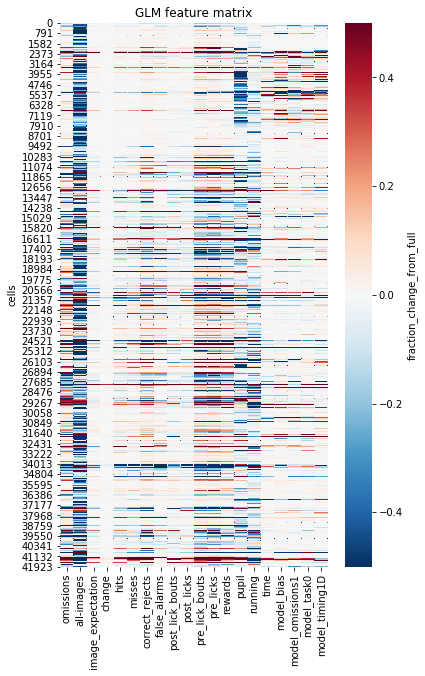

In [18]:
feature_matrix = rspm[cols_for_clustering]
fig, ax = plt.subplots(figsize=(6,10))
ax = sns.heatmap(feature_matrix, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=ax, cbar_kws={'label':model_output_type})
ax.set_ylabel('cells')
ax.set_title('GLM feature matrix')

Text(0.5, 1, 'GLM feature matrix')

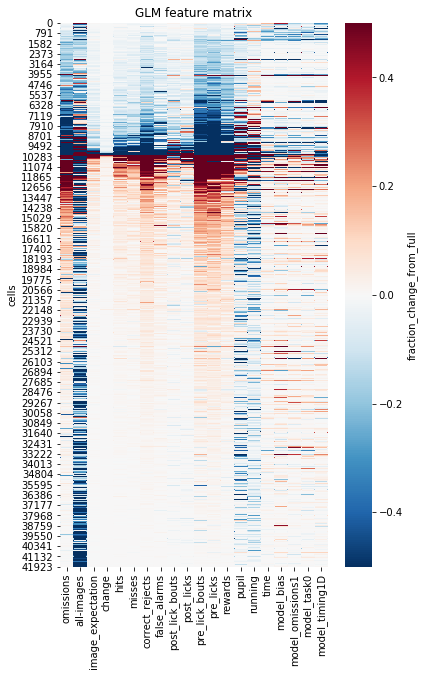

In [19]:
# sorted by overall variance explaned
feature_matrix = rspm.sort_values('varience_explained_full_model').reset_index()[cols_for_clustering]
fig, ax = plt.subplots(figsize=(6,10))
ax = sns.heatmap(feature_matrix, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=ax, cbar_kws={'label':model_output_type})
ax.set_ylabel('cells')
ax.set_title('GLM feature matrix')

Text(0.5, 1, 'GLM feature matrix')

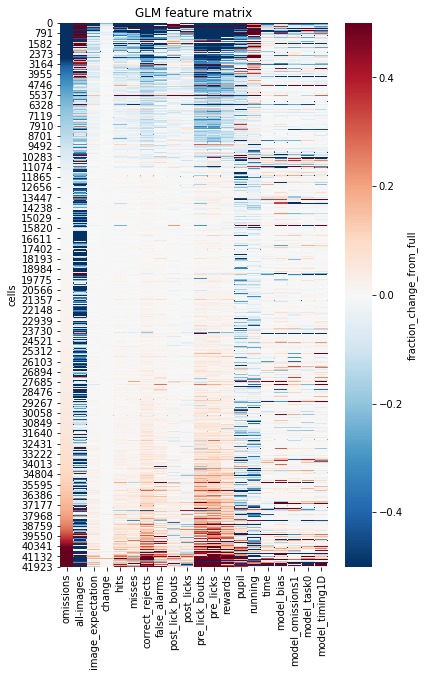

In [20]:
# sorted by omission dropout
feature_matrix = rspm.sort_values('omissions').reset_index()[cols_for_clustering]
fig, ax = plt.subplots(figsize=(6,10))
ax = sns.heatmap(feature_matrix, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=ax, cbar_kws={'label':model_output_type})
ax.set_ylabel('cells')
ax.set_title('GLM feature matrix')

### do k-means on the full feature matrix

In [21]:
# create kmeans object
kmeans = KMeans(n_clusters=4)

In [22]:
# fit kmeans object to data
kmeans.fit(rspm[cols_for_clustering])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [23]:
rspm['k-means_cluster_id'] = kmeans.fit_predict(rspm[cols_for_clustering])

#### how many clusters do we get? 

In [24]:
rspm['k-means_cluster_id'].value_counts()

0    42677
3        1
2        1
1        1
Name: k-means_cluster_id, dtype: int64

### make a tsne plot

In [25]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [26]:
tsne_results = tsne.fit_transform(rspm[cols_for_clustering])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 42680 samples in 0.069s...
[t-SNE] Computed neighbors for 42680 samples in 26.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42680
[t-SNE] Computed conditional probabilities for sample 2000 / 42680
[t-SNE] Computed conditional probabilities for sample 3000 / 42680
[t-SNE] Computed conditional probabilities for sample 4000 / 42680
[t-SNE] Computed conditional probabilities for sample 5000 / 42680
[t-SNE] Computed conditional probabilities for sample 6000 / 42680
[t-SNE] Computed conditional probabilities for sample 7000 / 42680
[t-SNE] Computed conditional probabilities for sample 8000 / 42680
[t-SNE] Computed conditional probabilities for sample 9000 / 42680
[t-SNE] Computed conditional probabilities for sample 10000 / 42680
[t-SNE] Computed conditional probabilities for sample 11000 / 42680
[t-SNE] Computed conditional probabilities for sample 12000 / 42680
[t-SNE] Computed conditional probabilities for s

#### assign tsne reults to new columns

In [27]:
rspm['tsne-2d-one'] = tsne_results[:,0]
rspm['tsne-2d-two'] = tsne_results[:,1]

In [28]:
rspm['session_type'].unique()

array(['OPHYS_1_images_B', 'OPHYS_3_images_B', 'OPHYS_4_images_A',
       'OPHYS_6_images_A', 'OPHYS_1_images_A', 'OPHYS_3_images_A',
       'OPHYS_4_images_B', 'OPHYS_6_images_B'], dtype=object)

### make a histogram of the omission dropout values

Text(0.5, 0, 'omissions dropout fractional change in var explained')

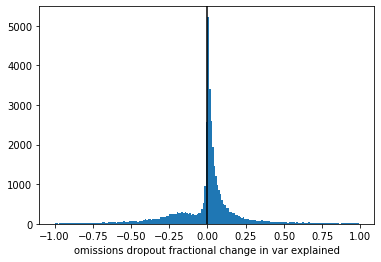

In [29]:
fig,ax=plt.subplots()
ax.hist(rspm['omissions'],bins=np.arange(-1,1,0.01))
ax.axvline(0,color='black')
ax.set_xlabel('omissions dropout fractional change in var explained')

### make a new column that identifies cells as 'modulated' by running or omissions (the threshold is up for debate!)

In [30]:
def is_modulated(v, threshold=0):
    return v < threshold
rspm['omission_modulated'] = rspm['omissions'].map(lambda v:is_modulated(v, threshold=0))
rspm['running_modulated'] = rspm['running'].map(lambda v:is_modulated(v, threshold=0))

### plot the tsne results, coloring dots in different ways
It looks like they cluster almost perfectly by omission modulation!

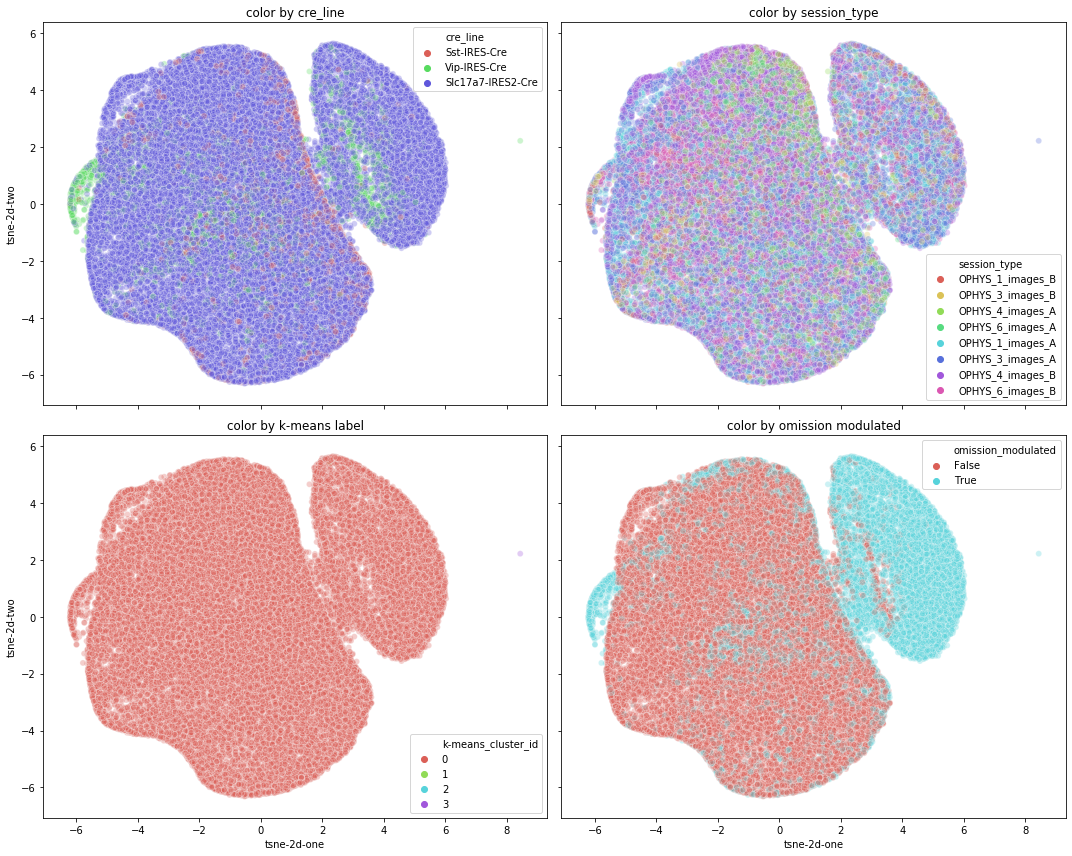

In [31]:

fig,ax=plt.subplots(2,2,figsize=(15,12),sharey=True,sharex=True)
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="cre_line",
    palette=sns.color_palette("hls", 3),
    data=rspm,
    legend="full",
    alpha=0.3,
    ax=ax[0,0]
)
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="session_type",
    palette=sns.color_palette("hls", 8),
    data=rspm,
    legend="full",
    alpha=0.3,
    ax=ax[0,1]
)
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="k-means_cluster_id",
    palette=sns.color_palette("hls", 4),
    data=rspm,
    legend="full",
    alpha=0.3,
    ax=ax[1,0]
)
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='omission_modulated',
    palette=sns.color_palette("hls", 2),
    data=rspm,
    legend="full",
    alpha=0.3,
    ax=ax[1,1]
)
fig.tight_layout()
for ii,hue in enumerate(['cre_line','session_type','k-means label', 'omission modulated']):
    ax.flatten()[ii].set_title('color by {}'.format(hue))
fig.tight_layout()

### plot tsne again, grouped by cre-line

Text(0.5, 1.0, 'Sst only')

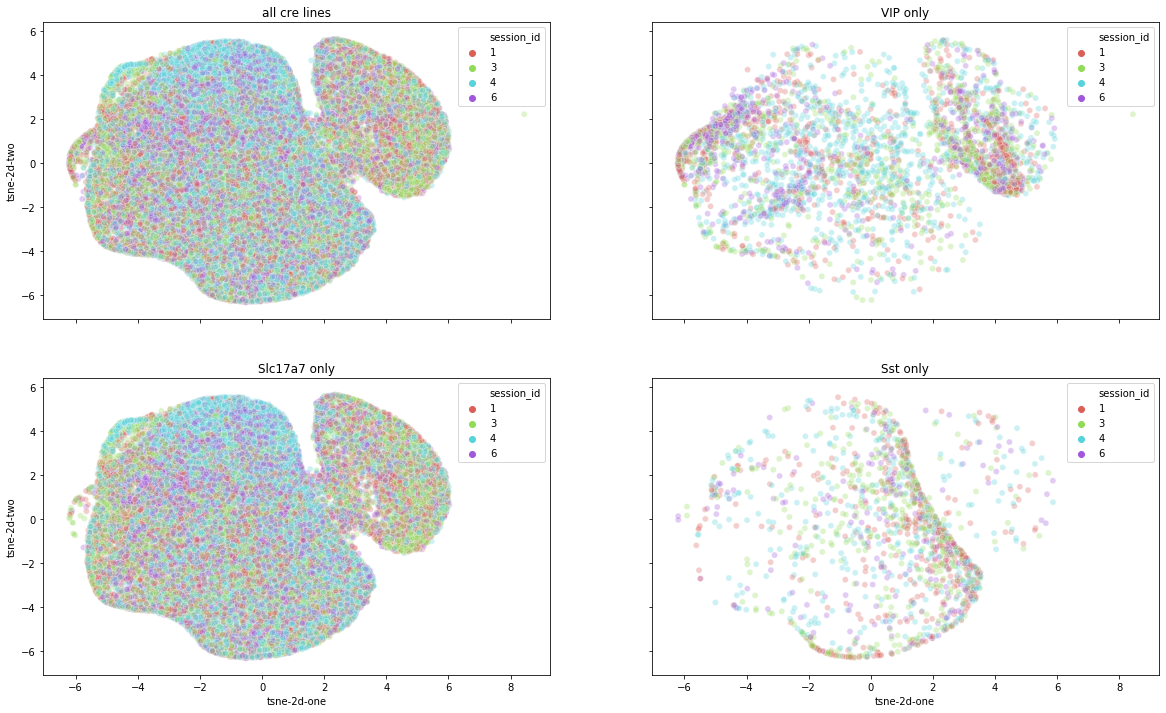

In [32]:
fig,ax=plt.subplots(2,2,figsize=(20,12),sharey=True,sharex=True)
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="session_id",
    palette=sns.color_palette("hls", 4),
    data=rspm, #.query('cre_line=="Vip-IRES-Cre"'),
    legend='full',
    alpha=0.3,
    ax=ax[0,0]
)
ax[0,0].set_title('all cre lines')

sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="session_id",
    palette=sns.color_palette("hls", 4),
    data=rspm.query('cre_line=="Vip-IRES-Cre"'),
    legend='full',
    alpha=0.3,
    ax=ax[0,1]
)
ax[0,1].set_title('VIP only')

sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="session_id",
    palette=sns.color_palette("hls", 4),
    data=rspm.query('cre_line=="Slc17a7-IRES2-Cre"'),
    legend='full',
    alpha=0.3,
    ax=ax[1,0]
)
ax[1,0].set_title('Slc17a7 only')

sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue="session_id",
    palette=sns.color_palette("hls", 4),
    data=rspm.query('cre_line=="Sst-IRES-Cre"'),
    legend='full',
    alpha=0.3,
    ax=ax[1,1]
)
ax[1,1].set_title('Sst only')

### plot tsne again, colored continuously by the omissions dropout

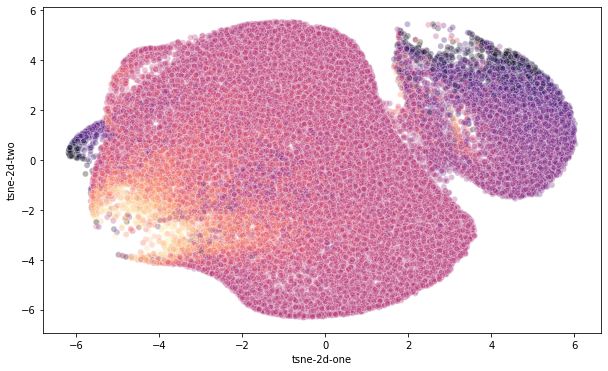

In [33]:
fig,ax=plt.subplots(1,1,figsize=(10,6),sharey=True,sharex=True)
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='omissions',
    palette='magma',
    data=rspm.query('omissions>-1 and omissions<1'),
    legend=False,
    alpha=0.3,
    ax=ax
)


### do kmeans clustring on the tsne space
It kinda works

In [34]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(rspm[cols_for_clustering])
tsne_cols = ['tsne-2d-one','tsne-2d-two']
rspm['k-means_on_tSNE'] = kmeans.fit_predict(rspm[tsne_cols])
rspm['k-means_on_tSNE'].value_counts()

1    21413
0    21267
Name: k-means_on_tSNE, dtype: int64

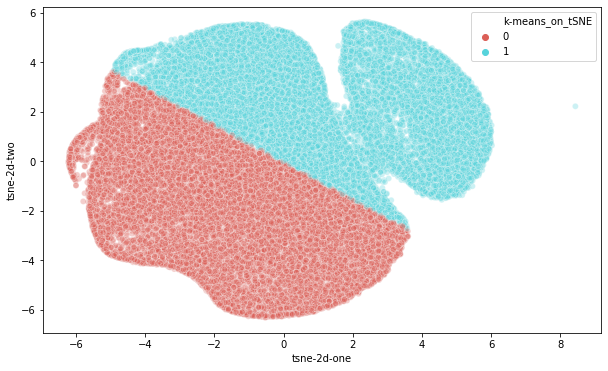

In [35]:
fig,ax=plt.subplots(1,1,figsize=(10,6),sharey=True,sharex=True)
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='k-means_on_tSNE',
    palette=sns.color_palette("hls", 2),
    data=rspm,
    legend='full',
    alpha=0.3,
    ax=ax,
)

### try agglomerative clustering?
It's also assigning to a single cluster

In [36]:
# # import hierarchical clustering libraries
# import scipy.cluster.hierarchy as sch
# from sklearn.cluster import AgglomerativeClustering

In [67]:

# # create clusters
# hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# # save clusters for chart
# y_hc = hc.fit_predict(rspm[cols_for_clustering])

In [68]:
# rspm['hc'] = y_hc
# rspm['hc'].value_counts()

# UMAP

In [69]:
import umap

min_dist = 0
spread=5
n_neighbors = 10
metric = 'euclidean'

reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, spread=spread)

mapper = reducer.fit(rspm[cols_for_clustering])

embedding = reducer.fit_transform(rspm[cols_for_clustering])
embedding.shape

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\umap\umap_.py:1158: RuntimeWarning:

divide by zero encountered in power

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\umap\umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



(42680, 2)

In [70]:
mapper.embedding_.shape

(42680, 2)

In [71]:
# save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\clustering\UMAP_output'


In [72]:
# filepath = os.path.join(save_dir, '200810_UMAP_10D_GLM_fraction_change_in_explained_variance')
# np.save(file=filepath, arr=embedding_3d)

In [73]:
# filepath = os.path.join(save_dir, '200810_UMAP_3D_GLM_fraction_change_in_explained_variance')
# np.save(file=filepath, arr=embedding_3d)

In [74]:
# save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\clustering\UMAP_output'
# filepath = os.path.join(save_dir, '200810_UMAP_2D_GLM_fraction_change_in_explained_variance.npy')
# data = np.load(filepath)

### assign umap results to new columns

In [75]:
rspm['umap_embedding_0'] = embedding[:, 0]
rspm['umap_embedding_1'] = embedding[:, 1]
# rspm['umap_embedding_2'] = embedding[:, 2]


In [76]:
umap_cols = ['umap_embedding_0', 'umap_embedding_1']

### do kmeans on the 2d embedding
only two clusters since the 2d umap gives two clear clusters
k-means seems to identify them perfectly!

In [77]:
kmeans = KMeans(n_clusters=3)
umap_cols = ['umap_embedding_0','umap_embedding_1']
rspm['k-means_on_umap'] = kmeans.fit_predict(rspm[umap_cols])
rspm['k-means_on_umap'].value_counts()

1    16418
2    13168
0    13094
Name: k-means_on_umap, dtype: int64

### plot the results in 2D
k-means clearly didn't do a good job of identifying two of the three clusters

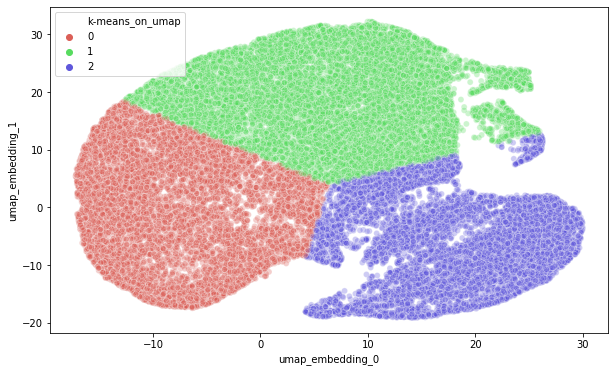

In [78]:
fig,ax=plt.subplots(1,1,figsize=(10,6),sharey=True,sharex=True)
sns.scatterplot(
    x='umap_embedding_0', 
    y='umap_embedding_1',
    hue='k-means_on_umap',
    palette=sns.color_palette("hls", 3),
    data=rspm,
    legend='full',
    alpha=0.3,
    ax=ax,
)

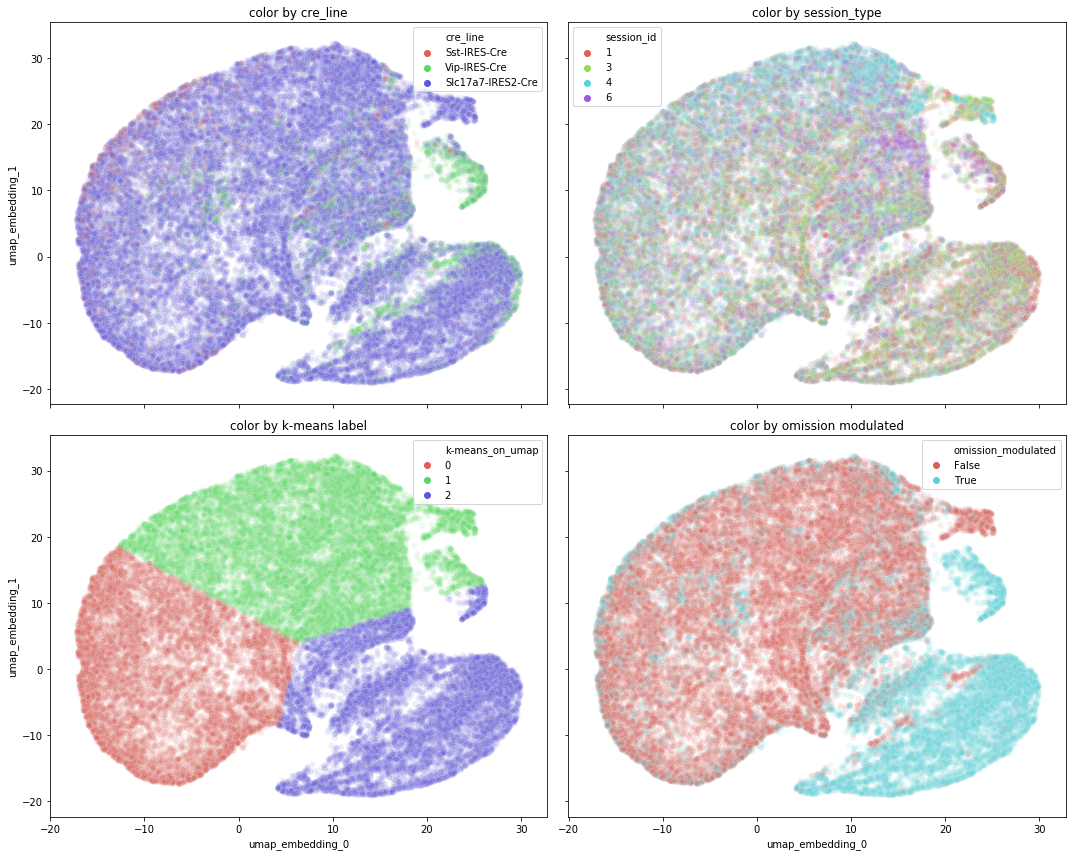

In [79]:
import seaborn as sns
fig,ax=plt.subplots(2,2,figsize=(15,12),sharey=True,sharex=True)
sns.scatterplot(
    x='umap_embedding_0', 
    y='umap_embedding_1',
    hue="cre_line",
    palette=sns.color_palette("hls", 3),
    data=rspm,
    legend="full",
    alpha=0.1,
    ax=ax[0,0]
)
sns.scatterplot(
    x='umap_embedding_0', 
    y='umap_embedding_1',
    hue="session_id",
    palette=sns.color_palette("hls", 4),
    data=rspm,
    legend="full",
    alpha=0.1,
    ax=ax[0,1]
)
sns.scatterplot(
    x='umap_embedding_0', 
    y='umap_embedding_1',
    hue='k-means_on_umap',
    palette=sns.color_palette("hls", len(rspm['k-means_on_umap'].unique())),
    data=rspm,
    legend="full",
    alpha=0.1,
    ax=ax[1,0]
)
sns.scatterplot(
    x='umap_embedding_0', 
    y='umap_embedding_1',
    hue='omission_modulated',
    palette=sns.color_palette("hls", 2),
    data=rspm,
    legend="full",
    alpha=0.1,
    ax=ax[1,1]
)
fig.tight_layout()
for ii,hue in enumerate(['cre_line','session_type','k-means label', 'omission modulated']):
    ax.flatten()[ii].set_title('color by {}'.format(hue))
fig.tight_layout()

### now make a 3d plotly plot of the same

In [80]:
# import plotly.express as px
# fig = px.scatter_3d(
#     rspm, 
#     x='umap_embedding_0', 
#     y='umap_embedding_1', 
#     z='umap_embedding_2',
#     color='k-means_on_umap'
# )
# fig.show()

### plot umap with omissions modulation as continuous color

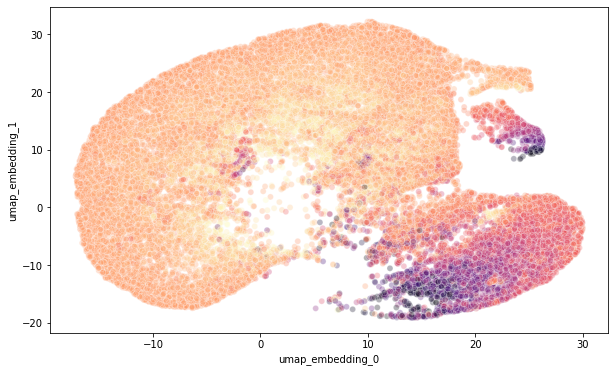

In [81]:
fig,ax=plt.subplots(1,1,figsize=(10,6),sharey=True,sharex=True)
ax = sns.scatterplot(
    x='umap_embedding_0', 
    y='umap_embedding_1',
    hue='omissions',
    palette='magma',
    data=rspm.query('omissions>-1 and omissions<0.25'),
    legend=False,
    alpha=0.3,
    ax=ax,
)
# plt.colorbar(cax=ax, title='omission_modulation')